# a04 Example - Optimization Scan Using AbstractRuninfoExitScanOptimizer: Runinfo to Alternate Variable Updates and Early Exit via Delta-Epsilon Threshold

In [1]:
import pyscan as ps
import numpy as np
import matplotlib.pyplot as plt
from time import sleep

## Setup devices

In [2]:
devices = ps.ItemAttribute()

devices.v1 = ps.TestVoltage() # Device 1
devices.v2 = ps.TestVoltage()

## Define a measure function

In [3]:
def voltage_response(v1, v2):
        return (v1 - 4)**2 + (v2 - 6)**2

def get_voltage_data(expt):
    """
    Reads the voltage from v1, v2, and v3 devices. Also adds a calculated value vsum.
    """

    runinfo = expt.runinfo
    devices = expt.devices

    d = ps.ItemAttribute()

    d.v1_readout = devices.v1.voltage
    d.v2_readout = devices.v2.voltage

    d.vf = voltage_response(d.v1_readout, d.v2_readout)
    
    return d

# Define Runinfo

In [4]:
runinfo =ps.RunInfo()
runinfo.measure_function = get_voltage_data

# Define an scan optimizer class

In [5]:
class FiniteDifferenceScanOptimizer(ps.AbstractRuninfoExitScanOptimizer):

    def __init__(self, runinfo, func,
                 input_delta=[1., 1.], epsilon=.1):
        super().__init__(runinfo)
        self.f = func
        self.in_delta = input_delta
        self.epsilon = epsilon
        self.keep_running_1 = True
        self.keep_running_2 = True
    
    def step_optimizer(self, fin1, fin2, fout):

        def finite_difference(f_in, f_out, f, input_delta=1.):
            f_in_plus = f_in + input_delta
            f_out_plus = f(f_in_plus)
            f_delta_plus = f_out_plus - f_out
            if f_delta_plus < 0:
                return f_in_plus, f_delta_plus
            else:
                f_in_minus = f_in - input_delta
                f_out_minus = f(f_in_minus)
                f_delta_minus = f_out_minus - f_out
                return f_in_minus, f_delta_minus

        if self.runinfo.scan0.i % 2:
            f1 = lambda in1: self.f(in1, fin2)
            fin1_update, delta = finite_difference(fin1, fout, f1, input_delta=self.in_delta[0])
            self.keep_running_1 = abs(delta) > self.epsilon
            self.running = self.keep_running_1 or self.keep_running_2
            if self.keep_running_1:
                return [fin1_update, fin2]
            else:
                return [fin1, fin2]
        else:
            f2 = lambda in2: self.f(fin1, in2)
            fin2_update, delta = finite_difference(fin2, fout, f2, input_delta=self.in_delta[1])
            self.keep_running_2 = abs(delta) > self.epsilon
            self.running = self.keep_running_1 or self.keep_running_2
            if self.keep_running_2:
                return [fin1, fin2_update]
            else:
                return [fin1, fin2]


In [6]:
opt = FiniteDifferenceScanOptimizer(runinfo, voltage_response, input_delta=[.2, .3], epsilon=.1)

# Define Experiments

In [7]:
runinfo.scan0 = ps.OptimizeScan({'v1': 2., 'v2': 1}, prop='voltage', optimizer=opt,
                                optimizer_inputs=['v1_readout', 'v2_readout', 'vf'],
                                iteration_max=100)


# Run Experiments

In [8]:
expt = ps.Experiment(runinfo, devices, time=True)
expt.start_thread()

In [9]:
sleep(1) # wait for thread to finish

In [10]:
# ps.live_plot2D(expt, data_name="vf") # TODO: remove empty values from v1_voltage and v2_voltage

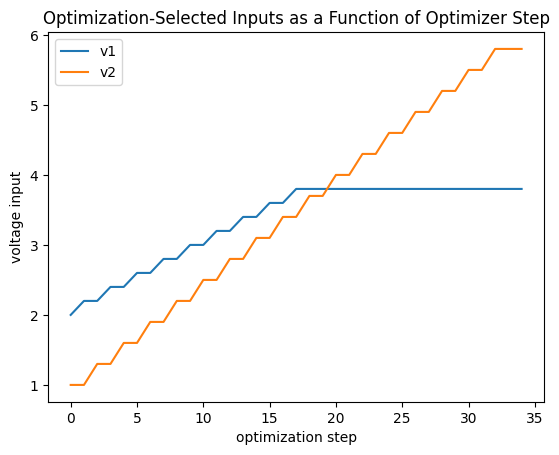

In [11]:
plt.plot(list(zip(expt.v1_readout, expt.v2_readout)))
plt.legend(['v1', 'v2'])
plt.xlabel("optimization step")
plt.ylabel("voltage input")
plt.title("Optimization-Selected Inputs as a Function of Optimizer Step");

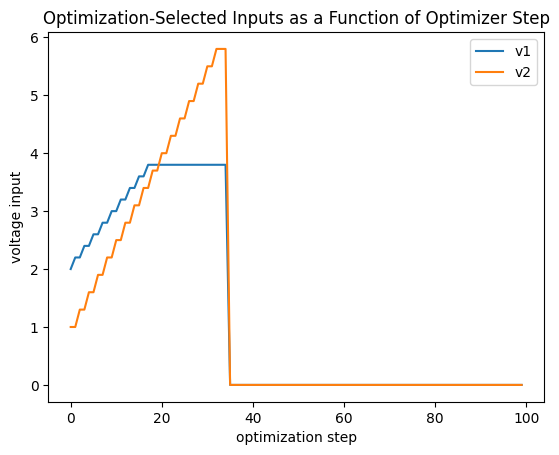

In [12]:
plt.plot(list(zip(expt.v1_voltage, expt.v2_voltage))) # TODO: trim unused inputs from scan dict?
plt.legend(['v1', 'v2'])
plt.xlabel("optimization step")
plt.ylabel("voltage input")
plt.title("Optimization-Selected Inputs as a Function of Optimizer Step");

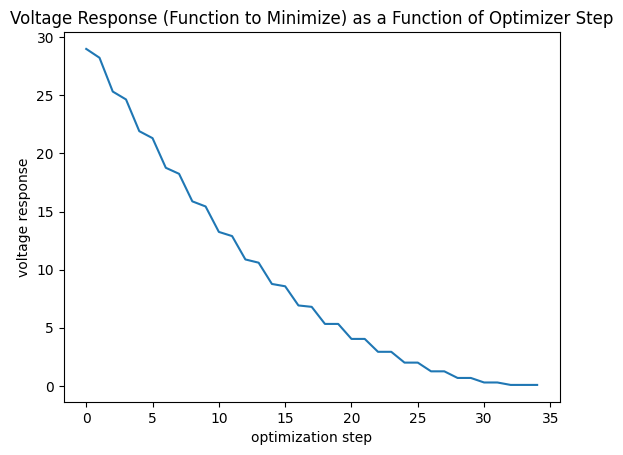

In [13]:
plt.plot(expt.vf)
plt.xlabel("optimization step")
plt.ylabel("voltage response")
plt.title("Voltage Response (Function to Minimize) as a Function of Optimizer Step");

In [14]:
def plot_optim(elevation, azimuth):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    scatter = ax.scatter(expt.v1_voltage, expt.v2_voltage, expt.vf, c=range(len(expt.v1_voltage)))
    x, y = np.mgrid[0:10:.01, 0:10:.01]
    z = np.array(voltage_response(np.ravel(x), np.ravel(y)))
    z = z.reshape(x.shape)
    ax.plot_surface(x, y, z, color='C1', alpha=.5)
    ax.view_init(elev=elevation, azim=azimuth)
    fig.colorbar(scatter, label="optimizer step")
    ax.legend(["optimizer decision process", "voltage response function"], loc='center right', bbox_to_anchor=(2, .5))
    ax.set_xlabel("v1_voltage input")
    ax.set_ylabel("v2_voltage input")
    ax.set_zlabel("voltage response")
    ax.set_title("Optimizer Decision Process and Voltage Response Function (Function to Minimize)")

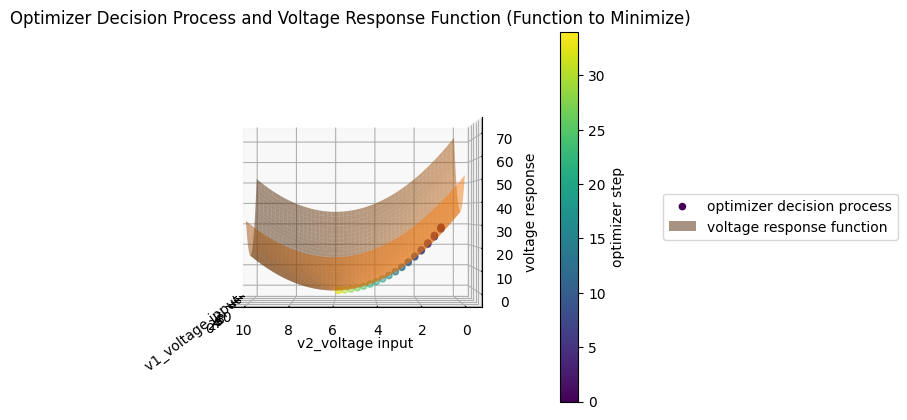

In [15]:
plot_optim(0, 180)

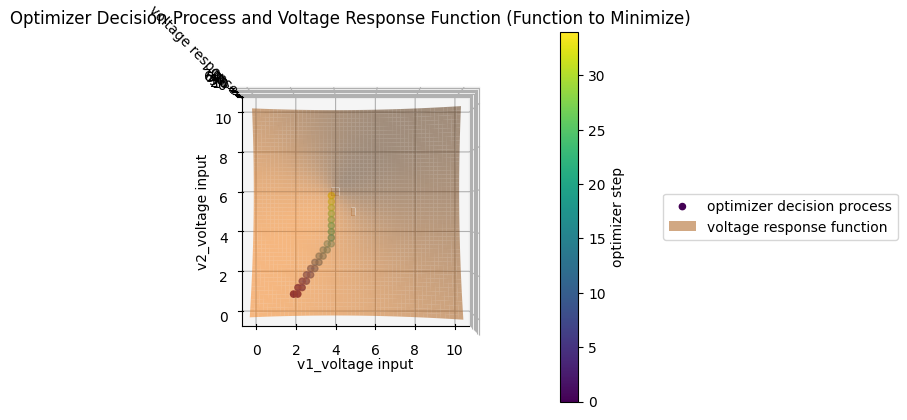

In [16]:
plot_optim(90, 270)

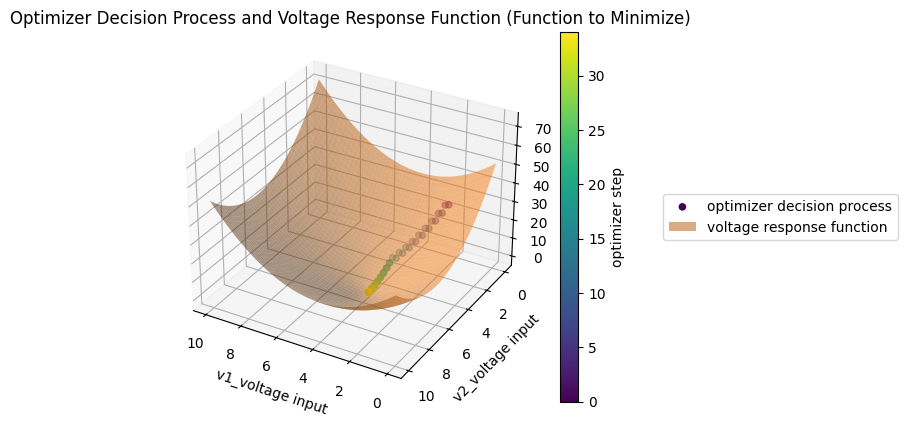

In [17]:
plot_optim(30, 120)